In [1]:
import os
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:

# ------------------ FEDformer (Simplified) ------------------
class FourierBlock(nn.Module):
    """Lightweight frequency-domain attention block."""
    def __init__(self, top_k=10):
        super().__init__()
        self.top_k = top_k

    def forward(self, x):
        # x: (batch, seq_len, features)
        x_ft = torch.fft.rfft(x, dim=1)  # frequency domain
        abs_x = torch.abs(x_ft)

        # Select top-k frequencies
        topk = torch.topk(abs_x, self.top_k, dim=1).indices
        mask = torch.zeros_like(abs_x)
        mask.scatter_(1, topk, 1.0)
        x_ft_filtered = x_ft * mask

        x_ifft = torch.fft.irfft(x_ft_filtered, n=x.size(1), dim=1)
        return x_ifft

class FEDformer(nn.Module):
    def __init__(self, seq_len, n_features, forecast_horizon, d_model=128, top_k=10):
        super().__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.d_model = d_model
        self.top_k = top_k
        
        self.enc_embedding = nn.Linear(n_features, d_model)
        self.fourier_block = FourierBlock(top_k)
        self.trend_block = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, forecast_horizon)
    
    def forward(self, x):
        x = self.enc_embedding(x)  # (B, seq_len, d_model)
        seasonal = self.fourier_block(x)
        trend = self.trend_block(x)
        combined = seasonal + trend
        pooled = combined.mean(dim=1)
        out = self.fc_out(pooled)
        return out

In [9]:
# ------------------ Dataset Preparation ------------------
def create_sequences(X_data, y_data, seq_len, forecast_horizon):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len - forecast_horizon):
        X_seq.append(X_data.iloc[i:i+seq_len].values)
        y_seq.append(y_data.iloc[i+seq_len:i+seq_len+forecast_horizon].values)
    return np.array(X_seq), np.array(y_seq)

def desequence(predictions, seq_len, forecast_horizon):
    total_length = len(predictions) + seq_len + forecast_horizon - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)
    for i in range(len(predictions)):
        start_idx = i + seq_len
        end_idx = start_idx + forecast_horizon
        merged_forecast[start_idx:end_idx] += predictions[i]
        count[start_idx:end_idx] += 1
    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast


In [10]:
# ------------------ Training ------------------
def train_fedformer(X_train, y_train, features, seq_len, forecast_horizon, epochs=10, batch_size=32):
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)

    X_seq, y_seq = create_sequences(X_train_scaled, y_train, seq_len, forecast_horizon)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.float32)

    train_dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    model = FEDformer(seq_len, len(features), forecast_horizon)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
    return model, scaler

In [11]:
# ------------------ Evaluation ------------------
def evaluate_fedformer(model, scaler, X_test, y_test,y_train_org, features, seq_len, forecast_horizon, time_index=None, start_point=0, end_point=None):

    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)
    X_seq, y_seq = create_sequences(X_test_scaled, y_test, seq_len, forecast_horizon)

    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor).numpy()



    merged_pred = desequence(preds, seq_len, forecast_horizon)
    merged_true = desequence(y_seq, seq_len, forecast_horizon)

    merged_pred = merged_pred[start_point:end_point]
    merged_true = merged_true[start_point:end_point]

        # Inverse scaling target
    y_scaler = StandardScaler()
    y_scaler.fit(y_train_org.values.reshape(-1, 1))  # use full original train target

    merged_true = y_scaler.inverse_transform(merged_true.reshape(-1, 1)).flatten()
    merged_pred = y_scaler.inverse_transform(merged_pred.reshape(-1, 1)).flatten()



    mse = mean_squared_error(merged_true, merged_pred)
    mae = mean_absolute_error(merged_true, merged_pred)
    rmse = math.sqrt(mse)

    print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    if time_index is not None:
        time_index = time_index[-len(merged_true):]
        plot_range = time_index
    else:
        plot_range = range(len(merged_true))

    if end_point is None:
        end_point = len(merged_true)

    plt.figure(figsize=(16, 6))
    plt.plot(plot_range, merged_true, label='Actual', color='black')
    plt.plot(plot_range, merged_pred, label='Forecast', color='red', linestyle='--')
    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("FEDformer Forecast vs Actual")
    plt.legend()
    plt.grid(True)
    textstr = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [12]:
seq_len = 24
forecast_horizon = 12

X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

X_train_aug = aug_train_processed[features]
y_train_aug = aug_train_processed[target]

X_test = org_test_processed[features]
y_test = org_test_processed[target]


In [13]:
print("Training FEDformer...")
model_fed, scaler_fed = train_fedformer(X_train_org, y_train_org, features, seq_len, forecast_horizon, epochs=100)


Training FEDformer...


Epoch 1: 100%|██████████| 4376/4376 [00:32<00:00, 134.35it/s]


Epoch 1, Loss: 0.0466


Epoch 2: 100%|██████████| 4376/4376 [00:28<00:00, 152.20it/s]


Epoch 2, Loss: 0.0405


Epoch 3: 100%|██████████| 4376/4376 [00:27<00:00, 159.36it/s]


Epoch 3, Loss: 0.0386


Epoch 4: 100%|██████████| 4376/4376 [00:31<00:00, 138.85it/s]


Epoch 4, Loss: 0.0375


Epoch 5: 100%|██████████| 4376/4376 [00:30<00:00, 142.24it/s]


Epoch 5, Loss: 0.0368


Epoch 6: 100%|██████████| 4376/4376 [00:28<00:00, 156.07it/s]


Epoch 6, Loss: 0.0364


Epoch 7: 100%|██████████| 4376/4376 [00:28<00:00, 155.44it/s]


Epoch 7, Loss: 0.0359


Epoch 8: 100%|██████████| 4376/4376 [00:27<00:00, 156.96it/s]


Epoch 8, Loss: 0.0357


Epoch 9: 100%|██████████| 4376/4376 [00:27<00:00, 156.98it/s]


Epoch 9, Loss: 0.0354


Epoch 10: 100%|██████████| 4376/4376 [00:28<00:00, 156.01it/s]


Epoch 10, Loss: 0.0353


Epoch 11: 100%|██████████| 4376/4376 [00:33<00:00, 128.88it/s]


Epoch 11, Loss: 0.0352


Epoch 12: 100%|██████████| 4376/4376 [00:29<00:00, 148.96it/s]


Epoch 12, Loss: 0.0350


Epoch 13: 100%|██████████| 4376/4376 [00:29<00:00, 150.66it/s]


Epoch 13, Loss: 0.0348


Epoch 14: 100%|██████████| 4376/4376 [00:28<00:00, 153.44it/s]


Epoch 14, Loss: 0.0347


Epoch 15: 100%|██████████| 4376/4376 [00:28<00:00, 156.03it/s]


Epoch 15, Loss: 0.0346


Epoch 16: 100%|██████████| 4376/4376 [00:29<00:00, 148.93it/s]


Epoch 16, Loss: 0.0345


Epoch 17: 100%|██████████| 4376/4376 [00:33<00:00, 128.96it/s]


Epoch 17, Loss: 0.0343


Epoch 18: 100%|██████████| 4376/4376 [00:28<00:00, 155.42it/s]


Epoch 18, Loss: 0.0343


Epoch 19: 100%|██████████| 4376/4376 [00:27<00:00, 157.48it/s]


Epoch 19, Loss: 0.0343


Epoch 20: 100%|██████████| 4376/4376 [00:27<00:00, 157.26it/s]


Epoch 20, Loss: 0.0342


Epoch 21: 100%|██████████| 4376/4376 [00:27<00:00, 156.66it/s]


Epoch 21, Loss: 0.0342


Epoch 22: 100%|██████████| 4376/4376 [00:27<00:00, 157.13it/s]


Epoch 22, Loss: 0.0340


Epoch 23: 100%|██████████| 4376/4376 [00:28<00:00, 153.50it/s]


Epoch 23, Loss: 0.0339


Epoch 24: 100%|██████████| 4376/4376 [00:28<00:00, 154.54it/s]


Epoch 24, Loss: 0.0339


Epoch 25: 100%|██████████| 4376/4376 [00:27<00:00, 157.98it/s]


Epoch 25, Loss: 0.0339


Epoch 26: 100%|██████████| 4376/4376 [00:27<00:00, 160.52it/s]


Epoch 26, Loss: 0.0338


Epoch 27: 100%|██████████| 4376/4376 [00:26<00:00, 162.23it/s]


Epoch 27, Loss: 0.0337


Epoch 28: 100%|██████████| 4376/4376 [00:27<00:00, 159.70it/s]


Epoch 28, Loss: 0.0337


Epoch 29: 100%|██████████| 4376/4376 [00:27<00:00, 159.72it/s]


Epoch 29, Loss: 0.0336


Epoch 30: 100%|██████████| 4376/4376 [00:27<00:00, 157.46it/s]


Epoch 30, Loss: 0.0337


Epoch 31: 100%|██████████| 4376/4376 [00:27<00:00, 157.27it/s]


Epoch 31, Loss: 0.0336


Epoch 32: 100%|██████████| 4376/4376 [00:27<00:00, 159.64it/s]


Epoch 32, Loss: 0.0334


Epoch 33: 100%|██████████| 4376/4376 [00:27<00:00, 161.23it/s]


Epoch 33, Loss: 0.0336


Epoch 34: 100%|██████████| 4376/4376 [00:27<00:00, 159.32it/s]


Epoch 34, Loss: 0.0335


Epoch 35: 100%|██████████| 4376/4376 [00:27<00:00, 160.96it/s]


Epoch 35, Loss: 0.0335


Epoch 36: 100%|██████████| 4376/4376 [00:27<00:00, 157.53it/s]


Epoch 36, Loss: 0.0335


Epoch 37: 100%|██████████| 4376/4376 [00:32<00:00, 133.40it/s]


Epoch 37, Loss: 0.0334


Epoch 38: 100%|██████████| 4376/4376 [00:30<00:00, 143.72it/s]


Epoch 38, Loss: 0.0334


Epoch 39: 100%|██████████| 4376/4376 [00:29<00:00, 150.68it/s]


Epoch 39, Loss: 0.0333


Epoch 40: 100%|██████████| 4376/4376 [00:27<00:00, 157.52it/s]


Epoch 40, Loss: 0.0332


Epoch 41: 100%|██████████| 4376/4376 [00:28<00:00, 155.24it/s]


Epoch 41, Loss: 0.0333


Epoch 42: 100%|██████████| 4376/4376 [00:27<00:00, 158.63it/s]


Epoch 42, Loss: 0.0333


Epoch 43: 100%|██████████| 4376/4376 [00:27<00:00, 159.80it/s]


Epoch 43, Loss: 0.0333


Epoch 44: 100%|██████████| 4376/4376 [00:27<00:00, 160.59it/s]


Epoch 44, Loss: 0.0331


Epoch 45: 100%|██████████| 4376/4376 [00:31<00:00, 140.04it/s]


Epoch 45, Loss: 0.0331


Epoch 46: 100%|██████████| 4376/4376 [00:30<00:00, 141.64it/s]


Epoch 46, Loss: 0.0332


Epoch 47: 100%|██████████| 4376/4376 [00:28<00:00, 152.21it/s]


Epoch 47, Loss: 0.0331


Epoch 48: 100%|██████████| 4376/4376 [00:26<00:00, 163.20it/s]


Epoch 48, Loss: 0.0330


Epoch 49: 100%|██████████| 4376/4376 [00:22<00:00, 195.88it/s]


Epoch 49, Loss: 0.0331


Epoch 50: 100%|██████████| 4376/4376 [00:11<00:00, 390.09it/s]


Epoch 50, Loss: 0.0330


Epoch 51: 100%|██████████| 4376/4376 [00:10<00:00, 429.41it/s]


Epoch 51, Loss: 0.0330


Epoch 52: 100%|██████████| 4376/4376 [00:10<00:00, 424.86it/s]


Epoch 52, Loss: 0.0329


Epoch 53: 100%|██████████| 4376/4376 [00:10<00:00, 424.74it/s]


Epoch 53, Loss: 0.0330


Epoch 54: 100%|██████████| 4376/4376 [00:10<00:00, 405.49it/s]


Epoch 54, Loss: 0.0331


Epoch 55: 100%|██████████| 4376/4376 [00:10<00:00, 420.58it/s]


Epoch 55, Loss: 0.0328


Epoch 56: 100%|██████████| 4376/4376 [00:10<00:00, 433.55it/s]


Epoch 56, Loss: 0.0328


Epoch 57: 100%|██████████| 4376/4376 [00:10<00:00, 436.22it/s]


Epoch 57, Loss: 0.0328


Epoch 58: 100%|██████████| 4376/4376 [00:10<00:00, 433.81it/s]


Epoch 58, Loss: 0.0329


Epoch 59: 100%|██████████| 4376/4376 [00:10<00:00, 415.57it/s]


Epoch 59, Loss: 0.0328


Epoch 60: 100%|██████████| 4376/4376 [00:10<00:00, 411.76it/s]


Epoch 60, Loss: 0.0328


Epoch 61: 100%|██████████| 4376/4376 [00:10<00:00, 423.41it/s]


Epoch 61, Loss: 0.0327


Epoch 62: 100%|██████████| 4376/4376 [00:10<00:00, 418.99it/s]


Epoch 62, Loss: 0.0327


Epoch 63: 100%|██████████| 4376/4376 [00:10<00:00, 419.03it/s]


Epoch 63, Loss: 0.0326


Epoch 64: 100%|██████████| 4376/4376 [00:10<00:00, 416.42it/s]


Epoch 64, Loss: 0.0327


Epoch 65: 100%|██████████| 4376/4376 [00:10<00:00, 421.50it/s]


Epoch 65, Loss: 0.0326


Epoch 66: 100%|██████████| 4376/4376 [00:10<00:00, 420.19it/s]


Epoch 66, Loss: 0.0325


Epoch 67: 100%|██████████| 4376/4376 [00:10<00:00, 417.90it/s]


Epoch 67, Loss: 0.0326


Epoch 68: 100%|██████████| 4376/4376 [00:10<00:00, 423.88it/s]


Epoch 68, Loss: 0.0326


Epoch 69: 100%|██████████| 4376/4376 [00:11<00:00, 391.53it/s]


Epoch 69, Loss: 0.0326


Epoch 70: 100%|██████████| 4376/4376 [00:10<00:00, 418.58it/s]


Epoch 70, Loss: 0.0325


Epoch 71: 100%|██████████| 4376/4376 [00:10<00:00, 423.08it/s]


Epoch 71, Loss: 0.0324


Epoch 72: 100%|██████████| 4376/4376 [00:10<00:00, 419.52it/s]


Epoch 72, Loss: 0.0325


Epoch 73: 100%|██████████| 4376/4376 [00:10<00:00, 419.48it/s]


Epoch 73, Loss: 0.0324


Epoch 74: 100%|██████████| 4376/4376 [00:10<00:00, 425.84it/s]


Epoch 74, Loss: 0.0324


Epoch 75: 100%|██████████| 4376/4376 [00:10<00:00, 423.11it/s]


Epoch 75, Loss: 0.0325


Epoch 76: 100%|██████████| 4376/4376 [00:11<00:00, 379.08it/s]


Epoch 76, Loss: 0.0324


Epoch 77: 100%|██████████| 4376/4376 [00:11<00:00, 378.33it/s]


Epoch 77, Loss: 0.0323


Epoch 78: 100%|██████████| 4376/4376 [00:11<00:00, 380.22it/s]


Epoch 78, Loss: 0.0323


Epoch 79: 100%|██████████| 4376/4376 [00:12<00:00, 353.77it/s]


Epoch 79, Loss: 0.0324


Epoch 80: 100%|██████████| 4376/4376 [00:11<00:00, 388.03it/s]


Epoch 80, Loss: 0.0322


Epoch 81: 100%|██████████| 4376/4376 [00:10<00:00, 413.20it/s]


Epoch 81, Loss: 0.0323


Epoch 82: 100%|██████████| 4376/4376 [00:10<00:00, 418.54it/s]


Epoch 82, Loss: 0.0322


Epoch 83: 100%|██████████| 4376/4376 [00:10<00:00, 424.29it/s]


Epoch 83, Loss: 0.0322


Epoch 84: 100%|██████████| 4376/4376 [00:10<00:00, 419.09it/s]


Epoch 84, Loss: 0.0322


Epoch 85: 100%|██████████| 4376/4376 [00:10<00:00, 415.92it/s]


Epoch 85, Loss: 0.0322


Epoch 86: 100%|██████████| 4376/4376 [00:11<00:00, 381.85it/s]


Epoch 86, Loss: 0.0322


Epoch 87: 100%|██████████| 4376/4376 [00:11<00:00, 390.23it/s]


Epoch 87, Loss: 0.0321


Epoch 88: 100%|██████████| 4376/4376 [00:10<00:00, 415.28it/s]


Epoch 88, Loss: 0.0321


Epoch 89: 100%|██████████| 4376/4376 [00:10<00:00, 422.57it/s]


Epoch 89, Loss: 0.0321


Epoch 90: 100%|██████████| 4376/4376 [00:10<00:00, 423.00it/s]


Epoch 90, Loss: 0.0321


Epoch 91: 100%|██████████| 4376/4376 [00:10<00:00, 422.62it/s]


Epoch 91, Loss: 0.0321


Epoch 92: 100%|██████████| 4376/4376 [00:10<00:00, 427.44it/s]


Epoch 92, Loss: 0.0321


Epoch 93: 100%|██████████| 4376/4376 [00:10<00:00, 423.64it/s]


Epoch 93, Loss: 0.0321


Epoch 94: 100%|██████████| 4376/4376 [00:10<00:00, 423.12it/s]


Epoch 94, Loss: 0.0320


Epoch 95: 100%|██████████| 4376/4376 [00:10<00:00, 398.91it/s]


Epoch 95, Loss: 0.0320


Epoch 96: 100%|██████████| 4376/4376 [00:10<00:00, 421.42it/s]


Epoch 96, Loss: 0.0320


Epoch 97: 100%|██████████| 4376/4376 [00:10<00:00, 424.79it/s]


Epoch 97, Loss: 0.0320


Epoch 98: 100%|██████████| 4376/4376 [00:10<00:00, 419.22it/s]


Epoch 98, Loss: 0.0319


Epoch 99: 100%|██████████| 4376/4376 [00:11<00:00, 376.95it/s]


Epoch 99, Loss: 0.0318


Epoch 100: 100%|██████████| 4376/4376 [00:10<00:00, 415.26it/s]


Epoch 100, Loss: 0.0319


In [15]:
import joblib

# Define file paths
filename = '../weights'
model_path = "FEDformer_org_model_no_shuffle.pth"
scaler_path = "scaler_FEDformer_org_no_shuffle.pkl"

# Save model weights
torch.save(model_fed.state_dict(), f'{filename}/{model_path}')

# Save scaler using joblib (more robust for sklearn objects)
joblib.dump(scaler_fed, f'{filename}/{scaler_path}')

print("Model and scaler saved successfully.")

Model and scaler saved successfully.


In [16]:
print("Training FEDformer...")
model_fed_aug, scaler_fed_aug = train_fedformer(X_train_aug, y_train_aug, features, seq_len, forecast_horizon, epochs=100)

Training FEDformer...


Epoch 1: 100%|██████████| 26262/26262 [01:37<00:00, 269.36it/s]


Epoch 1, Loss: 0.0393


Epoch 2: 100%|██████████| 26262/26262 [01:14<00:00, 352.23it/s]


Epoch 2, Loss: 0.0355


Epoch 3: 100%|██████████| 26262/26262 [01:06<00:00, 394.67it/s]


Epoch 3, Loss: 0.0346


Epoch 4: 100%|██████████| 26262/26262 [01:12<00:00, 362.95it/s]


Epoch 4, Loss: 0.0341


Epoch 5: 100%|██████████| 26262/26262 [01:25<00:00, 308.04it/s]


Epoch 5, Loss: 0.0338


Epoch 6: 100%|██████████| 26262/26262 [01:25<00:00, 307.75it/s]


Epoch 6, Loss: 0.0335


Epoch 7: 100%|██████████| 26262/26262 [01:22<00:00, 318.86it/s]


Epoch 7, Loss: 0.0333


Epoch 8: 100%|██████████| 26262/26262 [01:18<00:00, 336.35it/s]


Epoch 8, Loss: 0.0332


Epoch 9: 100%|██████████| 26262/26262 [01:22<00:00, 317.80it/s]


Epoch 9, Loss: 0.0330


Epoch 10: 100%|██████████| 26262/26262 [01:26<00:00, 303.90it/s]


Epoch 10, Loss: 0.0329


Epoch 11: 100%|██████████| 26262/26262 [01:23<00:00, 314.12it/s]


Epoch 11, Loss: 0.0327


Epoch 12: 100%|██████████| 26262/26262 [01:14<00:00, 350.36it/s]


Epoch 12, Loss: 0.0326


Epoch 13: 100%|██████████| 26262/26262 [01:18<00:00, 335.60it/s]


Epoch 13, Loss: 0.0324


Epoch 14: 100%|██████████| 26262/26262 [01:23<00:00, 316.38it/s]


Epoch 14, Loss: 0.0323


Epoch 15: 100%|██████████| 26262/26262 [01:24<00:00, 312.59it/s]


Epoch 15, Loss: 0.0322


Epoch 16: 100%|██████████| 26262/26262 [01:19<00:00, 328.53it/s]


Epoch 16, Loss: 0.0321


Epoch 17: 100%|██████████| 26262/26262 [01:19<00:00, 328.99it/s]


Epoch 17, Loss: 0.0320


Epoch 18: 100%|██████████| 26262/26262 [01:23<00:00, 315.94it/s]


Epoch 18, Loss: 0.0319


Epoch 19: 100%|██████████| 26262/26262 [01:25<00:00, 305.43it/s]


Epoch 19, Loss: 0.0318


Epoch 20: 100%|██████████| 26262/26262 [01:14<00:00, 350.90it/s]


Epoch 20, Loss: 0.0317


Epoch 21: 100%|██████████| 26262/26262 [01:20<00:00, 327.80it/s]


Epoch 21, Loss: 0.0316


Epoch 22: 100%|██████████| 26262/26262 [01:14<00:00, 350.27it/s]


Epoch 22, Loss: 0.0315


Epoch 23: 100%|██████████| 26262/26262 [01:18<00:00, 335.06it/s]


Epoch 23, Loss: 0.0314


Epoch 24: 100%|██████████| 26262/26262 [01:13<00:00, 358.22it/s]


Epoch 24, Loss: 0.0313


Epoch 25: 100%|██████████| 26262/26262 [01:18<00:00, 333.54it/s]


Epoch 25, Loss: 0.0312


Epoch 26: 100%|██████████| 26262/26262 [01:22<00:00, 318.27it/s]


Epoch 26, Loss: 0.0311


Epoch 27: 100%|██████████| 26262/26262 [01:18<00:00, 334.38it/s]


Epoch 27, Loss: 0.0311


Epoch 28: 100%|██████████| 26262/26262 [01:10<00:00, 372.44it/s]


Epoch 28, Loss: 0.0310


Epoch 29: 100%|██████████| 26262/26262 [01:25<00:00, 307.23it/s]


Epoch 29, Loss: 0.0309


Epoch 30: 100%|██████████| 26262/26262 [01:25<00:00, 306.36it/s]


Epoch 30, Loss: 0.0309


Epoch 31: 100%|██████████| 26262/26262 [01:24<00:00, 310.74it/s]


Epoch 31, Loss: 0.0308


Epoch 32: 100%|██████████| 26262/26262 [01:16<00:00, 342.04it/s]


Epoch 32, Loss: 0.0308


Epoch 33: 100%|██████████| 26262/26262 [01:31<00:00, 285.81it/s]


Epoch 33, Loss: 0.0307


Epoch 34: 100%|██████████| 26262/26262 [01:34<00:00, 278.91it/s]


Epoch 34, Loss: 0.0307


Epoch 35: 100%|██████████| 26262/26262 [01:32<00:00, 283.97it/s]


Epoch 35, Loss: 0.0306


Epoch 36: 100%|██████████| 26262/26262 [01:28<00:00, 297.45it/s]


Epoch 36, Loss: 0.0305


Epoch 37: 100%|██████████| 26262/26262 [01:28<00:00, 297.93it/s]


Epoch 37, Loss: 0.0305


Epoch 38: 100%|██████████| 26262/26262 [01:24<00:00, 309.22it/s]


Epoch 38, Loss: 0.0304


Epoch 39: 100%|██████████| 26262/26262 [01:25<00:00, 306.61it/s]


Epoch 39, Loss: 0.0304


Epoch 40: 100%|██████████| 26262/26262 [01:26<00:00, 302.01it/s]


Epoch 40, Loss: 0.0304


Epoch 41: 100%|██████████| 26262/26262 [01:26<00:00, 302.88it/s]


Epoch 41, Loss: 0.0303


Epoch 42: 100%|██████████| 26262/26262 [01:26<00:00, 302.42it/s]


Epoch 42, Loss: 0.0303


Epoch 43: 100%|██████████| 26262/26262 [01:25<00:00, 306.17it/s]


Epoch 43, Loss: 0.0302


Epoch 44: 100%|██████████| 26262/26262 [01:24<00:00, 312.01it/s]


Epoch 44, Loss: 0.0302


Epoch 45: 100%|██████████| 26262/26262 [01:21<00:00, 320.40it/s]


Epoch 45, Loss: 0.0302


Epoch 46: 100%|██████████| 26262/26262 [01:25<00:00, 306.26it/s]


Epoch 46, Loss: 0.0302


Epoch 47: 100%|██████████| 26262/26262 [01:23<00:00, 312.91it/s]


Epoch 47, Loss: 0.0302


Epoch 48: 100%|██████████| 26262/26262 [01:18<00:00, 334.44it/s]


Epoch 48, Loss: 0.0301


Epoch 49: 100%|██████████| 26262/26262 [01:19<00:00, 330.00it/s]


Epoch 49, Loss: 0.0301


Epoch 50: 100%|██████████| 26262/26262 [01:25<00:00, 305.74it/s]


Epoch 50, Loss: 0.0301


Epoch 51: 100%|██████████| 26262/26262 [01:19<00:00, 328.66it/s]


Epoch 51, Loss: 0.0300


Epoch 52: 100%|██████████| 26262/26262 [01:21<00:00, 323.36it/s]


Epoch 52, Loss: 0.0300


Epoch 53: 100%|██████████| 26262/26262 [01:25<00:00, 307.84it/s]


Epoch 53, Loss: 0.0299


Epoch 54: 100%|██████████| 26262/26262 [01:23<00:00, 313.30it/s]


Epoch 54, Loss: 0.0299


Epoch 55: 100%|██████████| 26262/26262 [01:21<00:00, 323.21it/s]


Epoch 55, Loss: 0.0299


Epoch 56: 100%|██████████| 26262/26262 [01:21<00:00, 321.74it/s]


Epoch 56, Loss: 0.0299


Epoch 57: 100%|██████████| 26262/26262 [01:14<00:00, 353.82it/s]


Epoch 57, Loss: 0.0299


Epoch 58: 100%|██████████| 26262/26262 [01:04<00:00, 406.28it/s]


Epoch 58, Loss: 0.0298


Epoch 59: 100%|██████████| 26262/26262 [01:05<00:00, 399.20it/s]


Epoch 59, Loss: 0.0298


Epoch 60: 100%|██████████| 26262/26262 [01:03<00:00, 411.46it/s]


Epoch 60, Loss: 0.0298


Epoch 61: 100%|██████████| 26262/26262 [01:04<00:00, 410.15it/s]


Epoch 61, Loss: 0.0298


Epoch 62: 100%|██████████| 26262/26262 [01:10<00:00, 372.22it/s]


Epoch 62, Loss: 0.0298


Epoch 63: 100%|██████████| 26262/26262 [01:08<00:00, 381.84it/s]


Epoch 63, Loss: 0.0298


Epoch 64: 100%|██████████| 26262/26262 [01:07<00:00, 387.46it/s]


Epoch 64, Loss: 0.0297


Epoch 65: 100%|██████████| 26262/26262 [01:17<00:00, 339.38it/s]


Epoch 65, Loss: 0.0297


Epoch 66: 100%|██████████| 26262/26262 [01:11<00:00, 367.38it/s]


Epoch 66, Loss: 0.0297


Epoch 67: 100%|██████████| 26262/26262 [01:08<00:00, 383.07it/s]


Epoch 67, Loss: 0.0297


Epoch 68: 100%|██████████| 26262/26262 [01:10<00:00, 371.71it/s]


Epoch 68, Loss: 0.0297


Epoch 69: 100%|██████████| 26262/26262 [01:22<00:00, 320.27it/s]


Epoch 69, Loss: 0.0296


Epoch 70: 100%|██████████| 26262/26262 [01:29<00:00, 293.55it/s]


Epoch 70, Loss: 0.0297


Epoch 71: 100%|██████████| 26262/26262 [01:27<00:00, 300.45it/s]


Epoch 71, Loss: 0.0296


Epoch 72: 100%|██████████| 26262/26262 [01:25<00:00, 306.78it/s]


Epoch 72, Loss: 0.0296


Epoch 73: 100%|██████████| 26262/26262 [01:26<00:00, 302.68it/s]


Epoch 73, Loss: 0.0296


Epoch 74: 100%|██████████| 26262/26262 [01:30<00:00, 289.18it/s]


Epoch 74, Loss: 0.0296


Epoch 75: 100%|██████████| 26262/26262 [01:27<00:00, 299.14it/s]


Epoch 75, Loss: 0.0296


Epoch 76: 100%|██████████| 26262/26262 [01:24<00:00, 309.11it/s]


Epoch 76, Loss: 0.0296


Epoch 77: 100%|██████████| 26262/26262 [01:17<00:00, 339.39it/s]


Epoch 77, Loss: 0.0295


Epoch 78: 100%|██████████| 26262/26262 [01:24<00:00, 312.23it/s]


Epoch 78, Loss: 0.0296


Epoch 79: 100%|██████████| 26262/26262 [01:26<00:00, 303.29it/s]


Epoch 79, Loss: 0.0295


Epoch 80: 100%|██████████| 26262/26262 [01:28<00:00, 296.48it/s]


Epoch 80, Loss: 0.0295


Epoch 81: 100%|██████████| 26262/26262 [01:27<00:00, 301.27it/s]


Epoch 81, Loss: 0.0295


Epoch 82: 100%|██████████| 26262/26262 [01:27<00:00, 301.85it/s]


Epoch 82, Loss: 0.0295


Epoch 83: 100%|██████████| 26262/26262 [01:34<00:00, 279.03it/s]


Epoch 83, Loss: 0.0295


Epoch 84: 100%|██████████| 26262/26262 [01:24<00:00, 311.60it/s]


Epoch 84, Loss: 0.0295


Epoch 85: 100%|██████████| 26262/26262 [01:20<00:00, 325.76it/s]


Epoch 85, Loss: 0.0295


Epoch 86: 100%|██████████| 26262/26262 [01:27<00:00, 300.07it/s]


Epoch 86, Loss: 0.0294


Epoch 87: 100%|██████████| 26262/26262 [01:13<00:00, 356.82it/s]


Epoch 87, Loss: 0.0294


Epoch 88: 100%|██████████| 26262/26262 [01:21<00:00, 323.58it/s]


Epoch 88, Loss: 0.0294


Epoch 89: 100%|██████████| 26262/26262 [01:27<00:00, 300.78it/s]


Epoch 89, Loss: 0.0294


Epoch 90: 100%|██████████| 26262/26262 [01:27<00:00, 299.56it/s]


Epoch 90, Loss: 0.0294


Epoch 91: 100%|██████████| 26262/26262 [01:25<00:00, 306.06it/s]


Epoch 91, Loss: 0.0294


Epoch 92: 100%|██████████| 26262/26262 [01:24<00:00, 309.62it/s]


Epoch 92, Loss: 0.0294


Epoch 93: 100%|██████████| 26262/26262 [01:26<00:00, 304.87it/s]


Epoch 93, Loss: 0.0293


Epoch 94: 100%|██████████| 26262/26262 [01:26<00:00, 302.92it/s]


Epoch 94, Loss: 0.0293


Epoch 95: 100%|██████████| 26262/26262 [01:21<00:00, 321.97it/s]


Epoch 95, Loss: 0.0293


Epoch 96: 100%|██████████| 26262/26262 [01:18<00:00, 335.85it/s]


Epoch 96, Loss: 0.0294


Epoch 97: 100%|██████████| 26262/26262 [01:18<00:00, 335.97it/s]


Epoch 97, Loss: 0.0294


Epoch 98: 100%|██████████| 26262/26262 [01:24<00:00, 310.90it/s]


Epoch 98, Loss: 0.0293


Epoch 99: 100%|██████████| 26262/26262 [01:13<00:00, 358.03it/s]


Epoch 99, Loss: 0.0293


Epoch 100: 100%|██████████| 26262/26262 [01:11<00:00, 365.66it/s]


Epoch 100, Loss: 0.0293


In [17]:
import joblib

# Define file paths
filename = '../weights'
model_path = "FEDformer_aug_modelV1_no_shuffle.pth"
scaler_path = "scaler_FEDformer_augV1_no_shuffle.pkl"

# Save model weights
torch.save(model_fed_aug.state_dict(), f'{filename}/{model_path}')

# Save scaler using joblib (more robust for sklearn objects)
joblib.dump(scaler_fed_aug, f'{filename}/{scaler_path}')

print("Model and scaler saved successfully.")

Model and scaler saved successfully.



Evaluating FEDformer...
Test MSE: 0.0031, MAE: 0.0447, RMSE: 0.0552


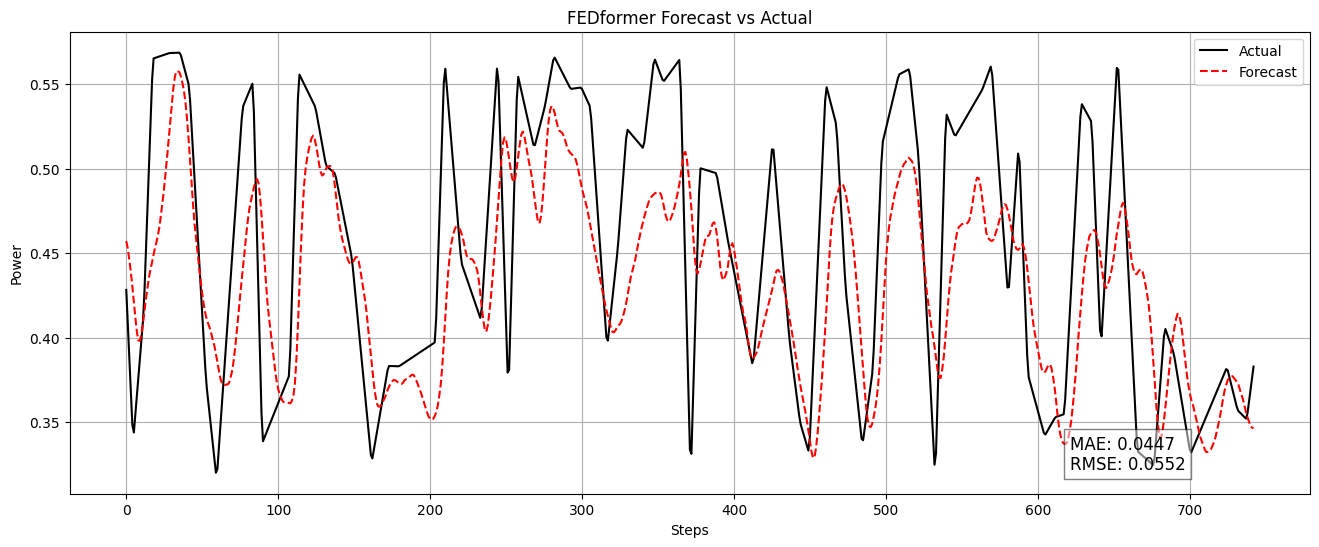

Test MSE: 0.0014, MAE: 0.0297, RMSE: 0.0375


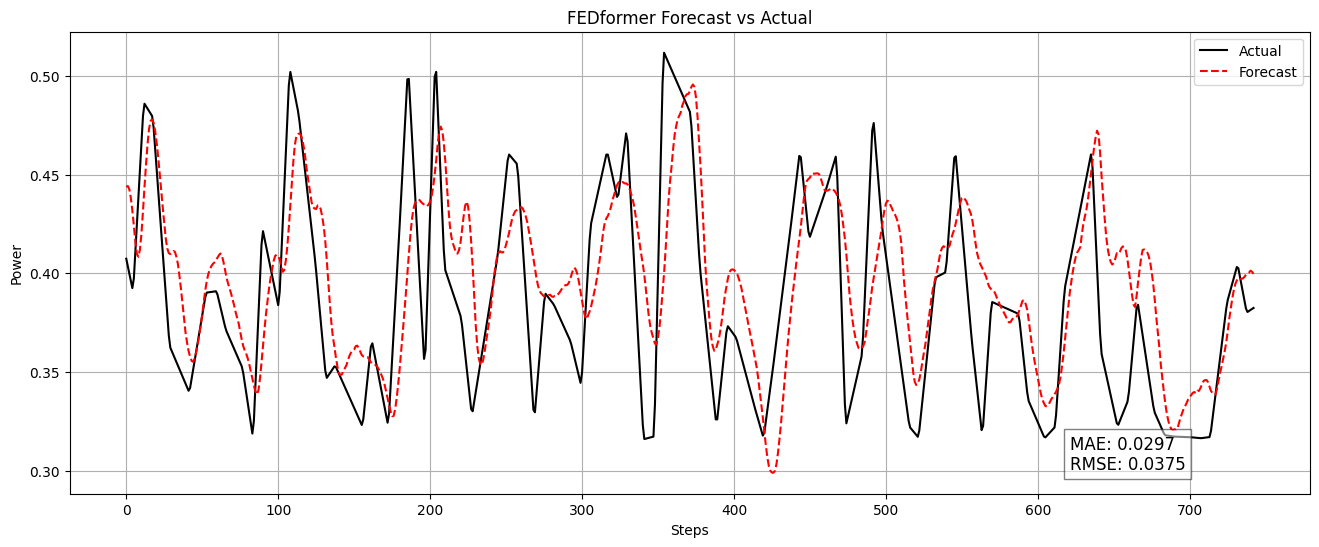

Test MSE: 0.0038, MAE: 0.0517, RMSE: 0.0619


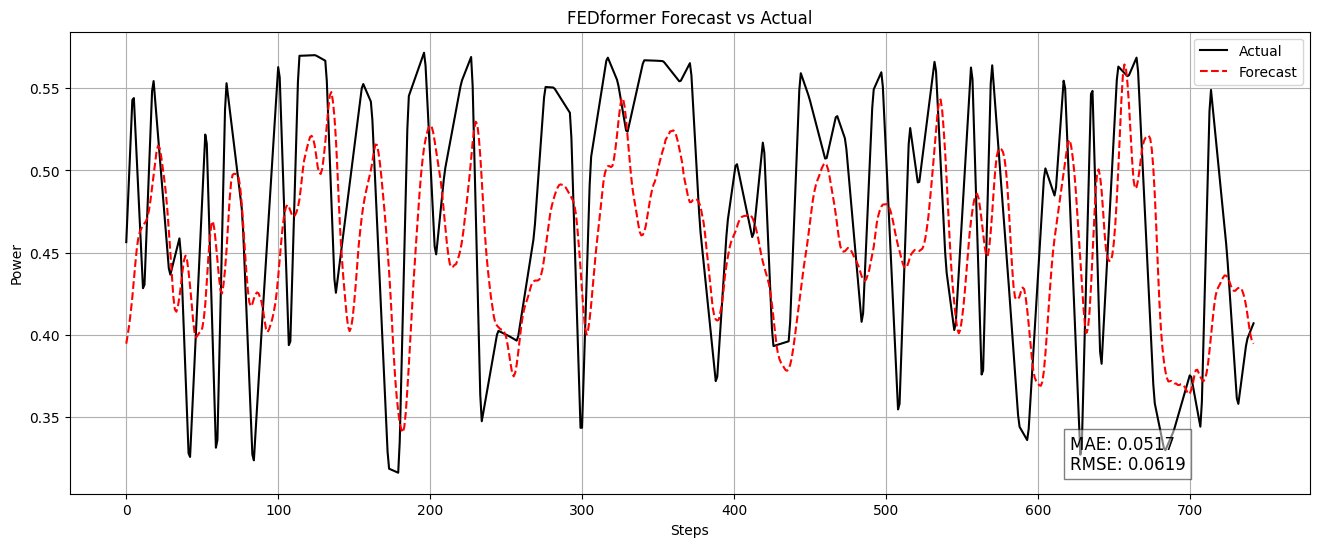

Test MSE: 0.0021, MAE: 0.0376, RMSE: 0.0456


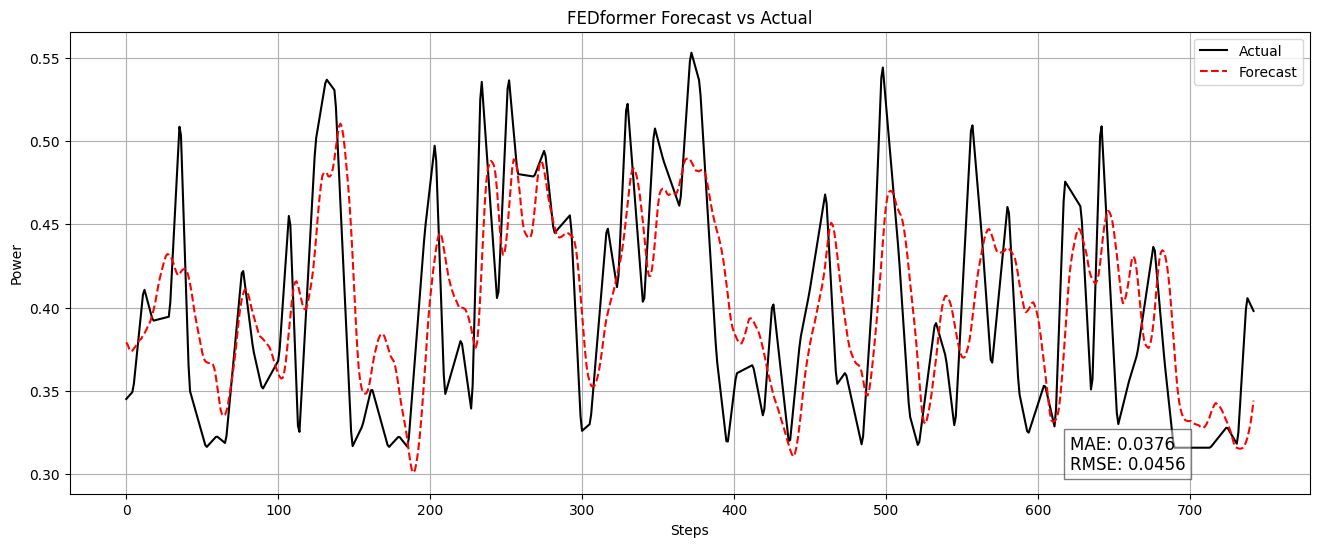

In [18]:
print("\nEvaluating FEDformer...")
evaluate_fedformer(model_fed_aug, scaler_fed_aug, X_test, y_test, y_train_aug, features, seq_len, forecast_horizon, start_point=7991, end_point=8734)
evaluate_fedformer(model_fed_aug, scaler_fed_aug, X_test, y_test, y_train_aug, features, seq_len, forecast_horizon, start_point=16726, end_point=17469)
evaluate_fedformer(model_fed_aug, scaler_fed_aug, X_test, y_test, y_train_aug, features, seq_len, forecast_horizon, start_point=25461, end_point=26204)
evaluate_fedformer(model_fed_aug, scaler_fed_aug, X_test, y_test, y_train_aug, features, seq_len, forecast_horizon, start_point=34196, end_point=34939)


Evaluating FEDformer...
Test MSE: 0.0035, MAE: 0.0473, RMSE: 0.0588


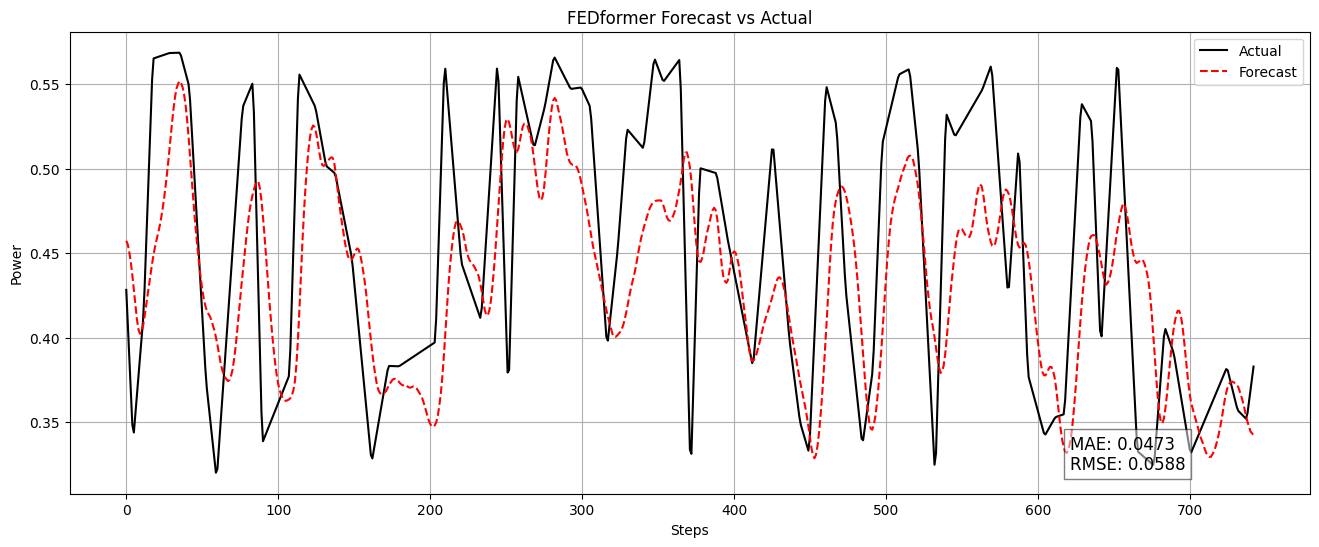

Test MSE: 0.0017, MAE: 0.0328, RMSE: 0.0416


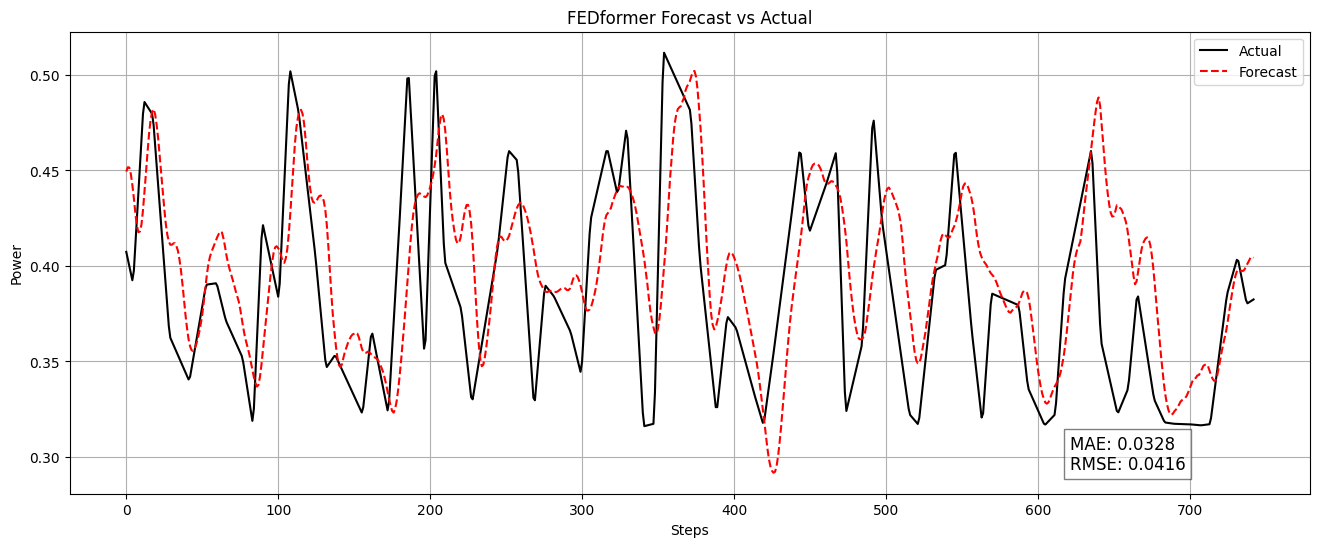

Test MSE: 0.0043, MAE: 0.0545, RMSE: 0.0655


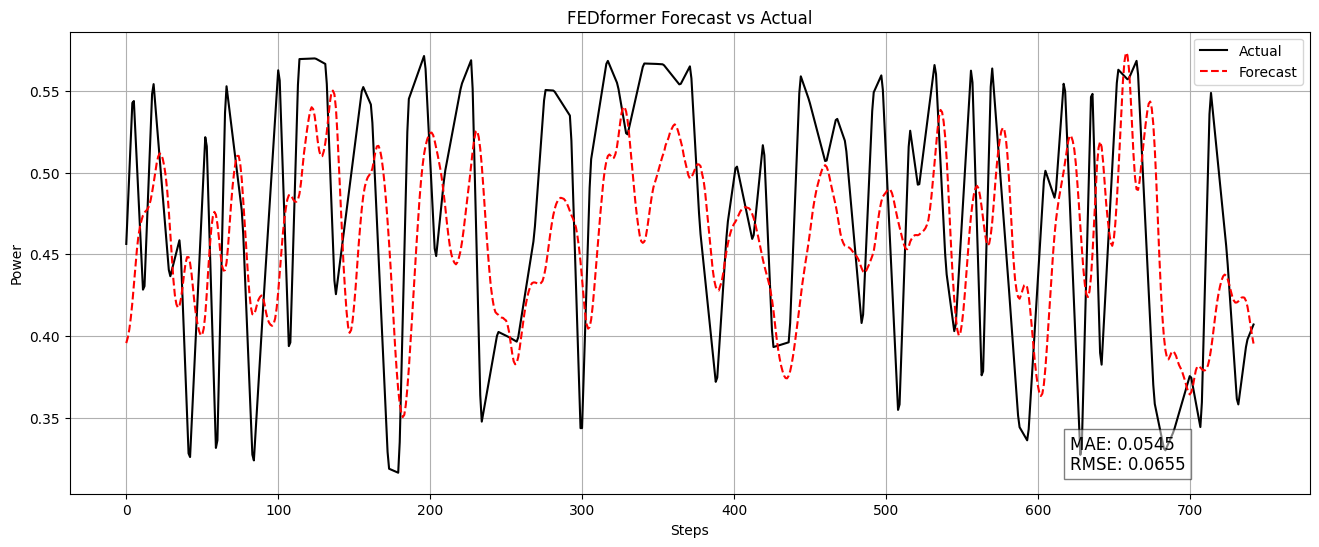

Test MSE: 0.0024, MAE: 0.0403, RMSE: 0.0492


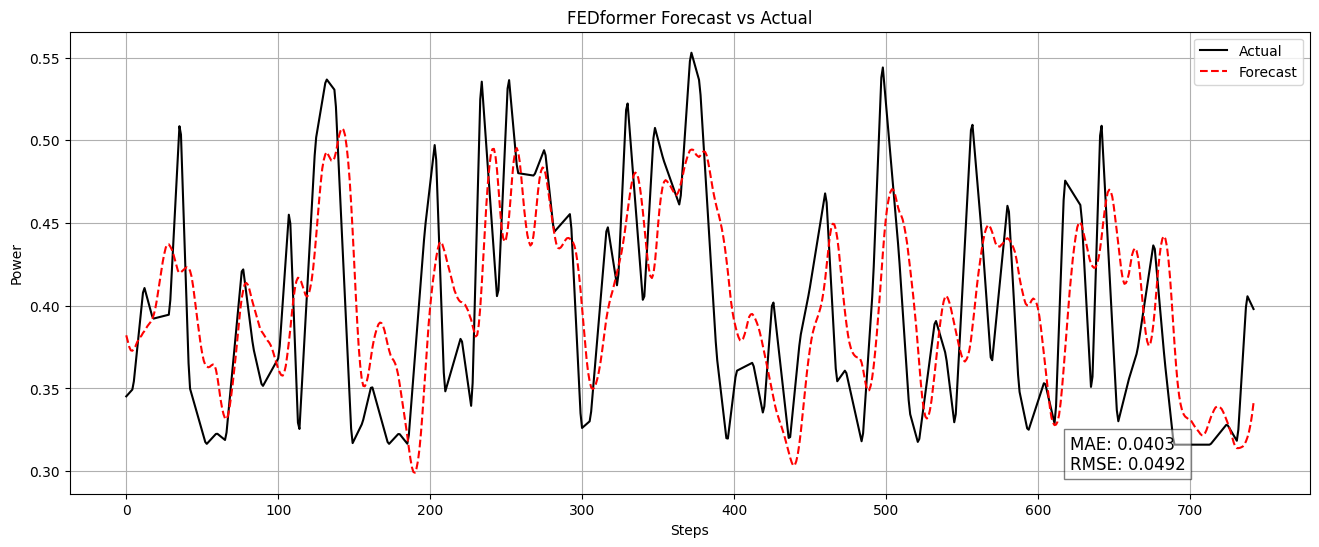

In [14]:
print("\nEvaluating FEDformer...")
evaluate_fedformer(model_fed, scaler_fed, X_test, y_test, y_train_aug, features, seq_len, forecast_horizon, start_point=7991, end_point=8734)
evaluate_fedformer(model_fed, scaler_fed, X_test, y_test, y_train_aug, features, seq_len, forecast_horizon, start_point=16726, end_point=17469)
evaluate_fedformer(model_fed, scaler_fed, X_test, y_test, y_train_aug, features, seq_len, forecast_horizon, start_point=25461, end_point=26204)
evaluate_fedformer(model_fed, scaler_fed, X_test, y_test, y_train_aug, features, seq_len, forecast_horizon, start_point=34196, end_point=34939)